## Visualizations

This notebook contains visualizations for the gathered data

- Threads x Speedup
- Threads x Efficiency (+ 100% efficiency line)
- Amdahl's law
- Overhead bars
- Solution quality

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
project_root = os.path.abspath('..')
data_path = os.path.join(project_root, 'results', 'data.csv')

In [27]:
df = pd.read_csv(data_path)
df.head()

,instance,size,mode,threads,time_ms,best_distance
0,u574,574,sequential,1,9347.8238,39519.8074
1,u574,574,sequential,1,8809.9147,39817.1522
2,u574,574,sequential,1,9084.5771,39262.2452
3,u574,574,parallel,1,8448.0244,39801.0782
4,u574,574,parallel,1,8535.9274,39968.6025


In [28]:
instances = df['instance'].unique()
thread_counts = sorted(df[df['mode'] == 'parallel']['threads'].unique())

In [36]:
grouped = df.groupby(['instance', 'mode', 'threads'], sort=False)['time_ms'].mean().reset_index()

sequential_baselines = grouped[grouped['mode'] == 'sequential'].set_index('instance')['time_ms']

grouped['speedup'] = grouped['instance'].map(sequential_baselines) / grouped['time_ms']
grouped['efficiency'] = (grouped['speedup'] / grouped['threads']) * 100

parallel_data = grouped[grouped['mode'] == 'parallel'].copy()
parallel_data['sequential_time'] = parallel_data['instance'].map(sequential_baselines)
parallel_data['ideal_time'] = parallel_data['sequential_time'] / parallel_data['threads']
parallel_data['overhead'] = parallel_data['time_ms'] - parallel_data['ideal_time']

parallel_data.head()

,instance,mode,threads,time_ms,speedup,efficiency,sequential_time,ideal_time,overhead
1,u574,parallel,1,8461.257367,1.073218,107.321778,9080.771867,9080.771867,-619.514500
2,u574,parallel,2,5223.668800,1.738390,86.919483,9080.771867,4540.385933,683.282867
3,u574,parallel,4,4210.415800,2.156740,53.918498,9080.771867,2270.192967,1940.222833
4,u574,parallel,8,4359.657600,2.082909,26.036368,9080.771867,1135.096483,3224.561117
5,u574,parallel,16,5075.114333,1.789274,11.182965,9080.771867,567.548242,4507.566092


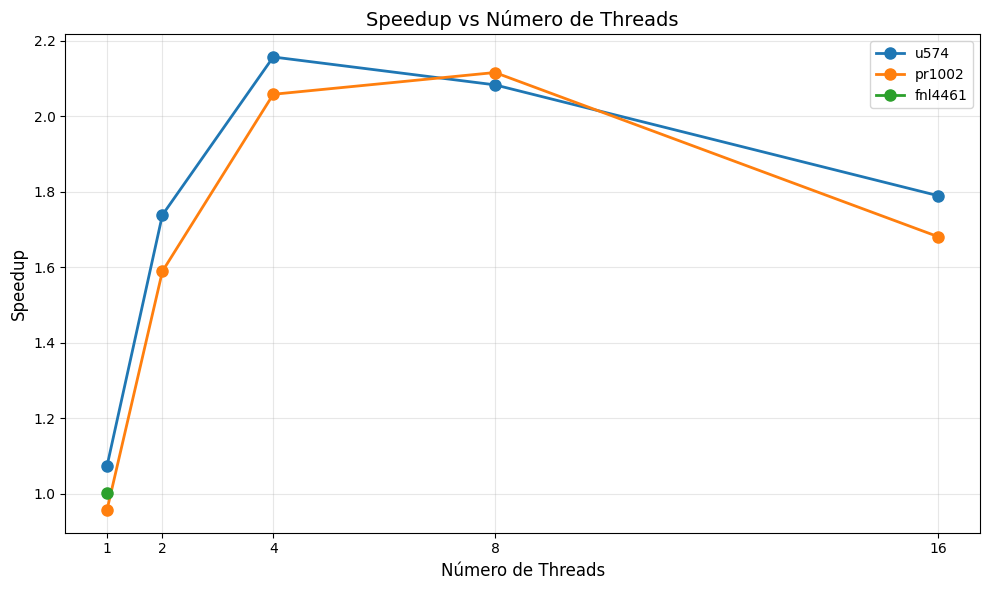

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

for instance in instances:
    instance_data = parallel_data[parallel_data['instance'] == instance]
    
    ax.plot(instance_data['threads'], 
            instance_data['speedup'],
            marker='o', 
            linewidth=2,
            markersize=8,
            label=instance)

ax.set_xlabel('Número de Threads', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.set_title('Speedup vs Número de Threads', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xticks(thread_counts)
plt.tight_layout()

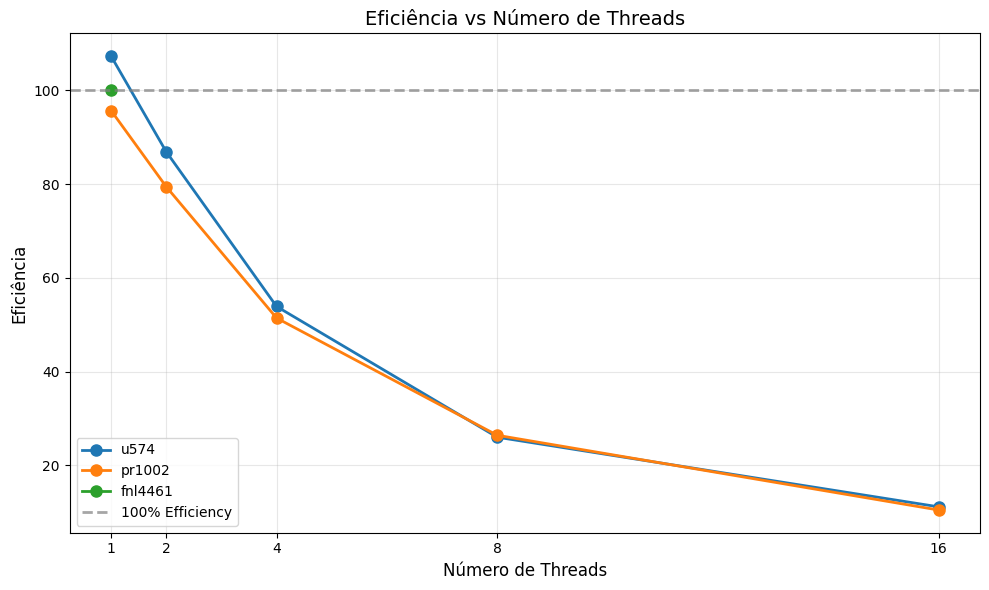

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

for instance in instances:
    instance_data = parallel_data[parallel_data['instance'] == instance]
    
    ax.plot(instance_data['threads'], 
            instance_data['efficiency'],
            marker='o', 
            linewidth=2,
            markersize=8,
            label=instance)
    
ax.axhline(y=100, 
        linestyle='--', 
        linewidth=2,
        color='gray', 
        alpha=0.7,
        label='100% Efficiency')

ax.set_xlabel('Número de Threads', fontsize=12)
ax.set_ylabel('Eficiência', fontsize=12)
ax.set_title('Eficiência vs Número de Threads', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xticks(thread_counts)
plt.tight_layout()

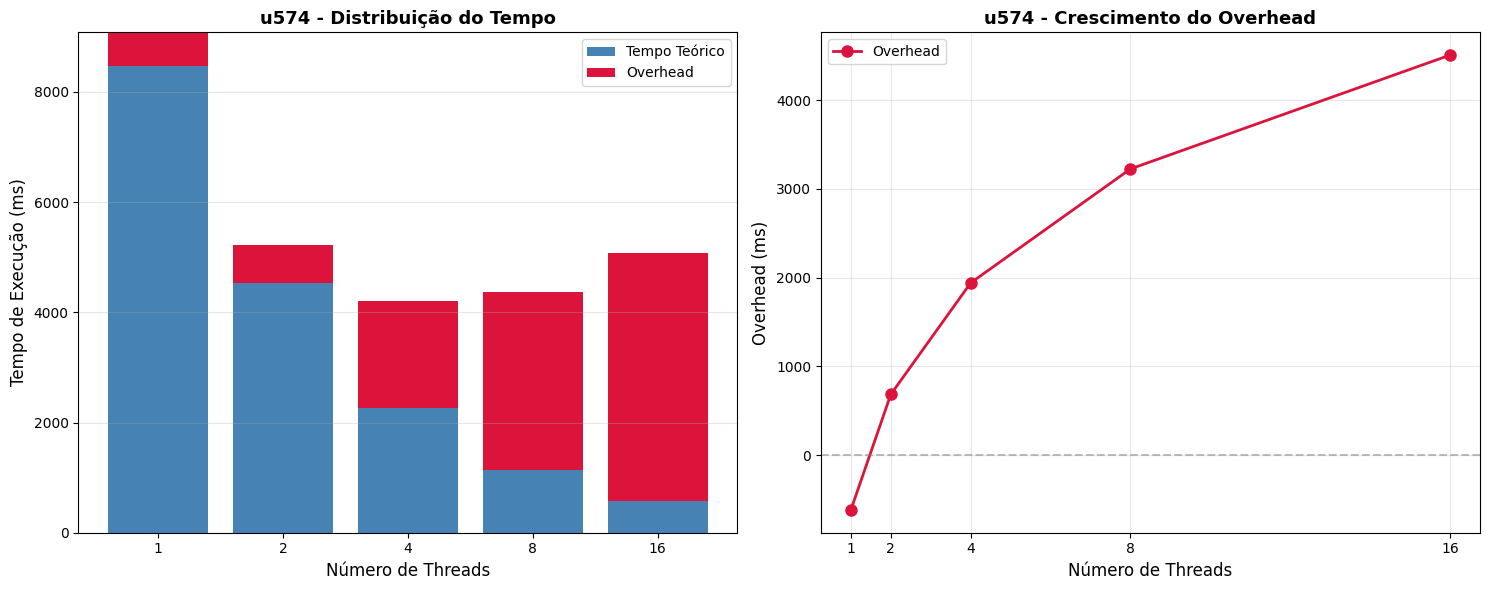

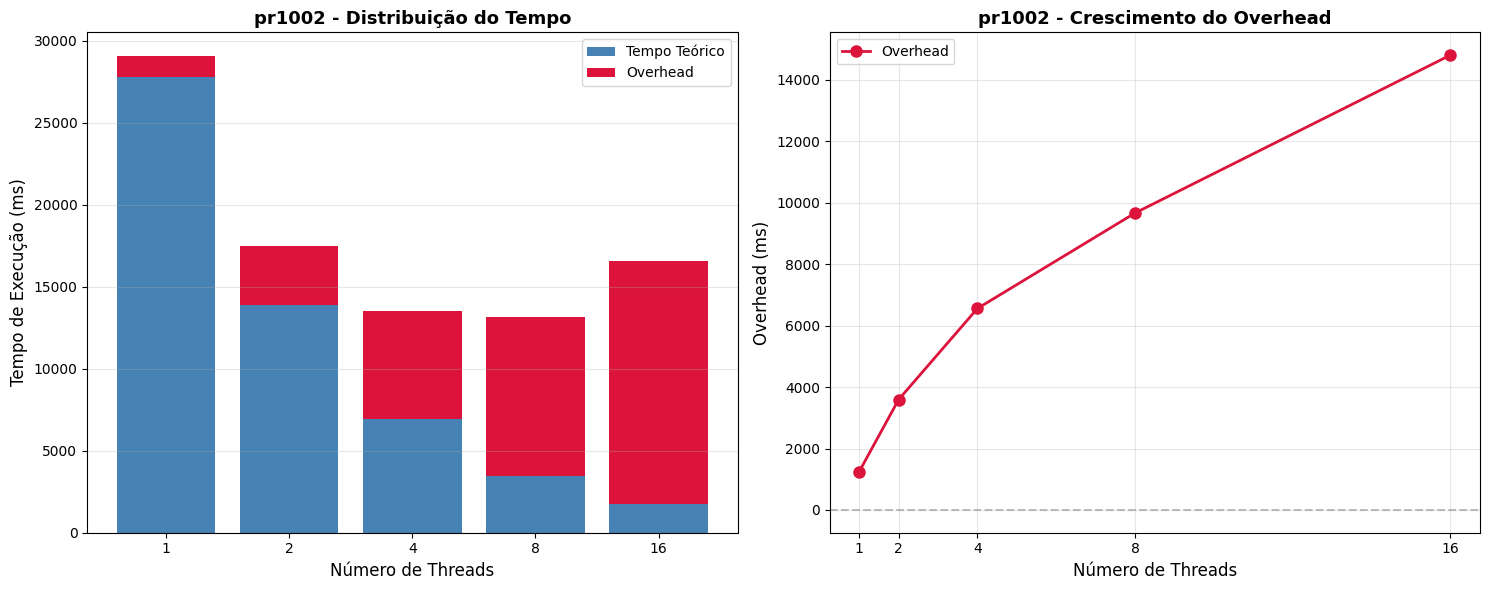

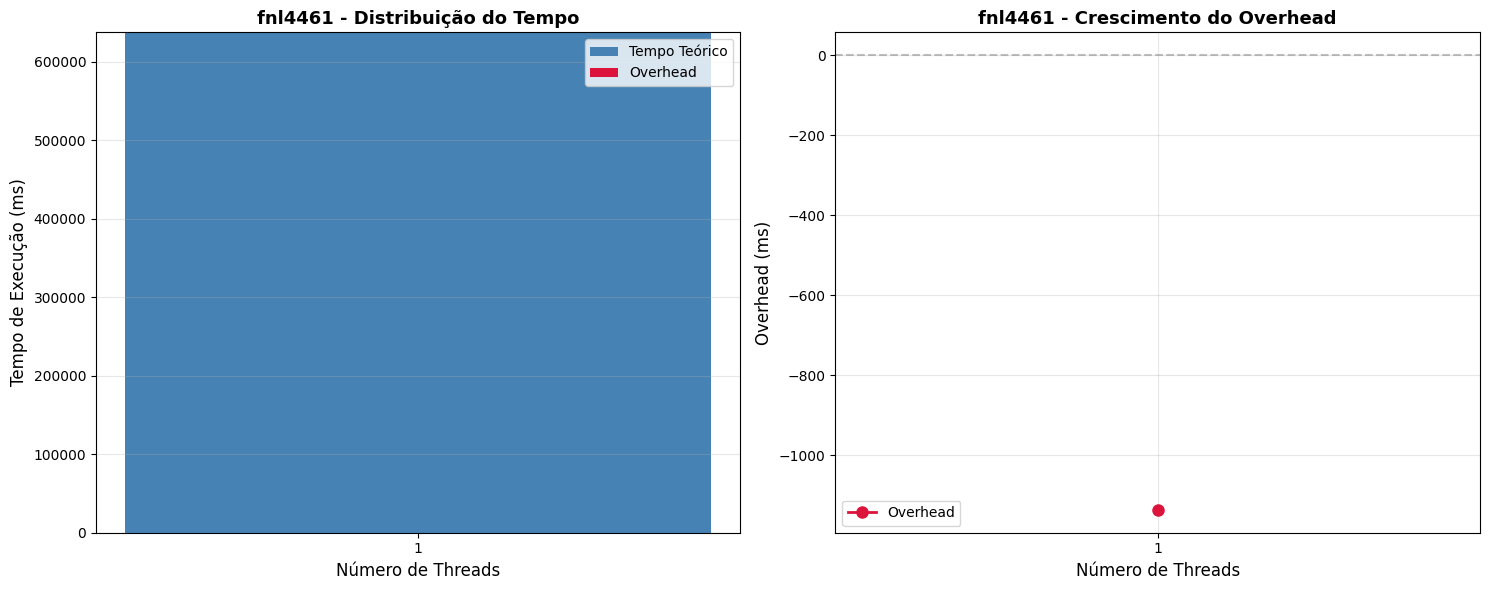

In [48]:
for instance in instances:
    instance_data = parallel_data[parallel_data['instance'] == instance]
    
    if len(instance_data) == 0:
        print(f"Skipping {instance}: no parallel data")
        continue
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    threads = instance_data['threads'].values
    ideal = instance_data['ideal_time'].values
    overhead = instance_data['overhead'].values
    
    x_pos = range(len(threads))
    
    # ===== PLOT 1: Stacked Bar Chart =====
    ax1.bar(x_pos, ideal, label='Tempo Teórico', color='steelblue')
    ax1.bar(x_pos, overhead, bottom=ideal, label='Overhead', color='crimson')
    
    ax1.set_xlabel('Número de Threads', fontsize=12)
    ax1.set_ylabel('Tempo de Execução (ms)', fontsize=12)
    ax1.set_title(f'{instance} - Distribuição do Tempo', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(threads)
    
    # ===== PLOT 2: Overhead Line Graph =====
    ax2.plot(threads, overhead,
             marker='o',
             linewidth=2,
             markersize=8,
             color='crimson',
             label='Overhead')
    
    ax2.set_xlabel('Número de Threads', fontsize=12)
    ax2.set_ylabel('Overhead (ms)', fontsize=12)
    ax2.set_title(f'{instance} - Crescimento do Overhead', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(threads)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()